* __Problem Statement__: The time within the food get delivered is a very important factor for a food delivery platform. This time taken is also responsible for popularity of a food delivery platform. If the delivery time of food is high then this could be a big issue for these platform, this could also led to loss of customers.
* __Aim__: Aim is to based on physical factors(location, weather, vehicle, traffic...) of the surroundings predict the time in which the food gets delivered.

In [1]:
import pandas as pd
import numpy as np

In [46]:
data = pd.read_csv('./data/finalTrain.csv')
data.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55,22:10,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,13-02-2022,14:55,15:05,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,04-03-2022,17:30,17:40,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,13-02-2022,09:20,09:30,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,14-02-2022,19:50,20:05,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41


In [47]:
# Handling latitude, longitude and time colummn so it is easy to feed into algorithm

def format_24_hour(Time: str) -> object:
    '''Returns string/NaN, If input is NaN then it return NaN, else based on the conditions.\n
        23:12 -> 23:12\n
        24:00 -> 00:00\n
        10:00:00 -> 10:00\n
        0.422 -> NaN\n
        NaN -> NaN'''
    try:
        # Convert 24:00 into 00:00
        if Time[:2] == '24':
            Time = '00' + Time[2:]
        
        # Convert 10:00:00 into 10:00
        if (n:=Time.count(':')) == 2:
            Time =  Time[:-3]

        # Convert decimal into NaN
        if n == 0:
            Time =  np.NaN
        
        return Time
    
    except:
        return Time

# Appling the format_24_hour function on both Time_Orderd and Time_Order_picked columns
data['Time_Orderd'] = data.Time_Orderd.apply(format_24_hour)
data['Time_Order_picked'] = data.Time_Order_picked.apply(format_24_hour)


order = data[data.Time_Orderd.notna() & data.Time_Order_picked.notna()]
# Converting the Time_Orderd into DateTime object
order_time = pd.to_datetime(order['Time_Orderd'])

# Converting the Time_Order_picked to DateTime object
order_picked = pd.to_datetime(order['Time_Order_picked'])

# Median difference between order picked and order time(seconds)
median_order_pick_time = (order_picked - order_time).dt.seconds.median()



# Selecting only those columns where Time_Ordered is NaN and Time_Order_picked is not NaN
order = data.loc[data.Time_Orderd.isna() & data.Time_Order_picked.notna()]

# Converting into DateTime object
order_picked = pd.to_datetime(order['Time_Order_picked'])

# Here subtracting Median Order Picking Time (600 seconds) from Order Picked Time
data['Time_Orderd'].fillna(
    value = (order_picked - pd.Timedelta(seconds = median_order_pick_time)).dt.strftime('%H:%M'), 
    inplace = True
    )


data['order_hour'] = data['Time_Orderd'].str.split(':', expand = True)[0].astype(float)

In [48]:
# as in EDA there  are some negitive values in coordinates

data[['Restaurant_latitude',
       'Restaurant_longitude', 
      'Delivery_location_latitude', 
      'Delivery_location_longitude']] = data[['Restaurant_latitude', 
                                              'Restaurant_longitude', 'Delivery_location_latitude', 

                                              'Delivery_location_longitude']].apply(np.abs)
# convert degree into radian
degree_radian = lambda x: x * (np.pi/180)

def globe_distance(data: pd.DataFrame, x1: str, y1: str, x2: str, y2: str) -> float:


    """Return the distance between (x1, y1) and (x2, y2), Where (x1, y1) are latitude and longitude of first location and 
    (x2, y2) are latitude and longitude of second location."""
    x1 = data[x1]
    y1 = data[y1]
    x2 = data[x2]
    y2 = data[y2]
    
    # Radius of earth (km)
    R = 6371
    lat_diff = degree_radian(x2 - x1) / 2
    lon_diff = degree_radian(y2 - y1) / 2
    d = np.square(np.sin(lat_diff)) + np.cos(degree_radian(x1)) * np.cos(degree_radian(x2)) * np.square(np.sin(lon_diff))
    D = 2 * R * np.arcsin(np.sqrt(d))
    return np.round(D, 2)

data['distance_rest_deliv'] = globe_distance(
        data = data, 
        x1 = 'Restaurant_latitude', 
        y1 = 'Restaurant_longitude', 
        x2 = 'Delivery_location_latitude', 
        y2 = 'Delivery_location_longitude'
        )

In [7]:
data.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),order_pick_delay,order_hour,distance_rest_deliv
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55,...,2,Snack,motorcycle,3.0,No,Metropolitian,46,15.0,21.0,10.28
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,13-02-2022,14:55,...,1,Meal,motorcycle,1.0,No,Metropolitian,23,10.0,14.0,6.24
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,04-03-2022,17:30,...,1,Drinks,scooter,1.0,No,Metropolitian,21,10.0,17.0,13.79
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,13-02-2022,09:20,...,0,Buffet,motorcycle,0.0,No,Metropolitian,20,10.0,9.0,2.93
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,14-02-2022,19:50,...,1,Snack,scooter,1.0,No,Metropolitian,41,15.0,19.0,19.40


Droping `ID` and `Delivery_person_ID` the reason is `ID` is unique.<br />
Also Droping Latitude, Longitude and Columns with datetime as these are converted into their respective numerical form.

In [49]:
data.drop(['ID'
    'Restaurant_latitude', 
    'Restaurant_longitude', 
    'Delivery_location_latitude', 
    'Delivery_location_longitude', 
    'Order_Date', 
    'Time_Orderd', 
    'Time_Order_picked'], axis = 1, inplace = True)

# seperating features and target
features = data.drop('Time_taken (min)', axis = 1)
target = data['Time_taken (min)'].values

In [50]:
features.head()

,Delivery_person_Age,Delivery_person_Ratings,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,order_pick_delay,order_hour,distance_rest_deliv
0,36.0,4.2,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,15.0,21.0,10.28
1,21.0,4.7,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,10.0,14.0,6.24
2,23.0,4.7,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,10.0,17.0,13.79
3,34.0,4.3,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,10.0,9.0,2.93
4,24.0,4.7,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,15.0,19.0,19.40


In [51]:
# Seperating categorical and numerical columns

cats_cols = features.select_dtypes(include = 'object').columns
nums_cols = features.select_dtypes(exclude = 'object').columns

In [52]:
# categories these are order by decresing delivery time
ID = data.groupby('ID')['Time_taken (min)'].median()
person_id_cats = ID.sort_values().index.to_list()
city_cats = ['Semi-Urban', 'Metropolitian', 'Urban']
festival_cats = ['Yes', 'No']
weather_cats = ['Fog', 'Cloudy', 'Stormy', 'Sandstorms', 'Windy', 'Sunny']
vehicle_cats = ['bicycle', 'scooter', 'electric_scooter', 'motorcycle']
order_cats = ['Buffet', 'Meal', 'Snack', 'Drinks']
traffic_cats = ['Jam', 'High', 'Medium', 'Low']

In [53]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [54]:
# Numerical Pipeline

nums_pipe = Pipeline(
    steps = (
        ('imputer', SimpleImputer( 
                            strategy = 'median'
                            )),
        ('scaling', StandardScaler())
    )
)
# Categorical Pipeline

cats_pipe = Pipeline(
    steps = (
        ('imputer', SimpleImputer(
                            strategy = 'most_frequent'
                            )),
        ('ordinalencoder', OrdinalEncoder(
                            categories = [
                                        person_id_cats,
                                        weather_cats, 
                                        traffic_cats, 
                                        order_cats, 
                                        vehicle_cats, 
                                        festival_cats, 
                                        city_cats]
                                    )),
        ('scaler', StandardScaler())
    )
)

preprocessor = ColumnTransformer(
    transformers = [
    ('Numerical_Pipeline', nums_pipe, nums_cols),
    ('Categorical_Pipeline', cats_pipe, cats_cols)
    ]
)


In [55]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test = tts(features, target, test_size = 0.3, random_state = 7)

In [56]:
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [57]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [58]:
linear = LinearRegression()

linear_regression = cross_val_score(
    estimator = linear,
    X = X_train,
    y = y_train,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)

linear_regression

array([-37.96580605, -39.06650086, -38.57474054, -39.01931147,
       -38.15301798])

In [59]:
linear_regression.mean()

-38.555875381238536

In [60]:
ridge = Ridge()
parameter = dict(alpha = [1e-10, 1e-5, 1e-2, 1e-1, 0, 1, 2, 3, 5, 10, 20, 30, 40, 50])

ridge_regression = GridSearchCV(
    estimator = ridge,
    param_grid = parameter,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    verbose = 1
)

score = ridge_regression.fit(X = X_train, y = y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [61]:
ridge_regression.best_params_

{'alpha': 20}

In [62]:
ridge_regression.best_score_

-38.55585600803739

In [63]:
lasso = Lasso()

parameter = dict(alpha = [1e-10, 1e-5, 1e-2, 1e-1, 1, 2, 3, 5, 10, 20, 30, 40, 50])

lasso_regression = GridSearchCV(
    estimator = lasso,
    param_grid = parameter,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    verbose = 1
)

score_lasso = lasso_regression.fit(X = X_train, y = y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


In [64]:
lasso_regression.best_params_

{'alpha': 1e-05}

In [65]:
lasso_regression.best_score_

-38.5558744270664

In [66]:
elastic = ElasticNet()

parameter = dict(alpha = [1e-10, 1e-5, 1e-2, 1e-1, 1, 2, 3, 5, 10, 20, 30, 40, 50])

elastic_regression = GridSearchCV(
    estimator = elastic,
    param_grid = parameter,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    verbose = 1
)

score_elastic = elastic_regression.fit(X = X_train, y = y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


In [67]:
elastic_regression.best_params_

{'alpha': 1e-05}

In [68]:
elastic_regression.best_score_

-38.5558746601085

In [69]:
print('Negitive Mean Square Error of Linear Regression is', linear_regression.mean())
print('Negitive Mean Square Error of Ridge Regression is', ridge_regression.best_score_)
print('Negitive Mean Square Error of Lasso Regression is', lasso_regression.best_score_)
print('Negitive Mean Square Error of Elastic Regression is', elastic_regression.best_score_)

Negitive Mean Square Error of Linear Regression is -38.555875381238536
Negitive Mean Square Error of Ridge Regression is -38.55585600803739
Negitive Mean Square Error of Lasso Regression is -38.5558744270664
Negitive Mean Square Error of Elastic Regression is -38.5558746601085


So Rigde, Lasso and Elastic Regression performing slightly better than Linear Regression

In [70]:
# Predictions

predict_ridge = ridge_regression.predict(X = X_test)
predict_lasso = lasso_regression.predict(X = X_test)
predict_elastic = elastic_regression.predict(X = X_test)

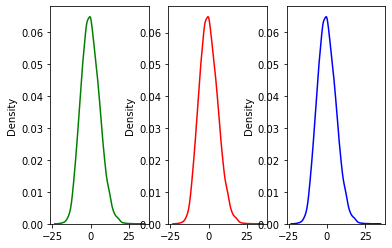

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3)
sns.kdeplot(y_test - predict_lasso, color = 'g', label = 'Lasso', ax = ax_1)
sns.kdeplot(y_test - predict_ridge, color = 'r', label = 'Ridge', ax = ax_2)
sns.kdeplot(y_test - predict_elastic, color = 'b', label = 'Elastic', ax = ax_3)
plt.show()


In [76]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [77]:
print('R2 Score of Ridge Regression:', r2_score(y_test, predict_ridge))
print('R2 Score of Lasso Regression:', r2_score(y_test, predict_lasso))
print('R2 Score of ElasticNet Regression:', r2_score(y_test, predict_elastic))

R2 Score of Ridge Regression: 0.5740671091913343
R2 Score of Lasso Regression: 0.5740676128847724
R2 Score of ElasticNet Regression: 0.5740676141547822


In [78]:
print('RMSE of Ridge Regression:', np.sqrt(mean_squared_error(y_test, predict_ridge)))
print('RMSE of Lasso Regression:', np.sqrt(mean_squared_error(y_test, predict_lasso)))
print('RMSE of ElasticNet Regression:', np.sqrt(mean_squared_error(y_test, predict_elastic)))

RMSE of Ridge Regression: 6.107314796756332
RMSE of Lasso Regression: 6.107311185606121
RMSE of ElasticNet Regression: 6.107311176500984


In [79]:
print('MAE of Ridge Regression:', mean_absolute_error(y_test, predict_ridge))
print('MAE of Lasso Regression:', mean_absolute_error(y_test, predict_lasso))
print('MAE of ElasticNet Regression:', mean_absolute_error(y_test, predict_elastic))

MAE of Ridge Regression: 4.878040981767208
MAE of Lasso Regression: 4.878027923258592
MAE of ElasticNet Regression: 4.878027952857319


Linear Regression is performing poor again Lasso, Ridge and Elastic. So for this problem I will use Lasso, Ridge and Elastic based on R2 score.